# AI Tango

## Model Experiments

First, load in dependencies, as well as the ModelBuilder which is meant for rapidly iterating on various options for our datasets and models.

In [23]:
from pose_parser.pose_parser.learning import model_builder as mb
from scipy.stats import randint

# Reloader
import importlib

# Mapping string categories to numerical
value_map = {
    "weight_transfer_type": {
        "Failure Weight Transfer": 0,
        "Successful Weight Transfer": 1,
    },
    "step_type": {
        "Left Step": 0,
        "Right Step": 1,
    },
}
# Columns we know we'll always want to drop
drop_list = ["video_id"]

# Columns we want to "white list" - this would be based on "important" features or specifically engineered
column_whitelist = [
    # "angles_max.line_5_6__line_6_7_angle_2d_degrees",
    # "angles_std.line_5_6__line_25_26_angle_2d_degrees",
    # "angles_avg.line_5_6__line_6_7_angle_2d_degrees",
    # "angles_avg.line_8_9__line_9_10_angle_2d_degrees",
    # "angles_max.line_5_6__line_25_26_angle_2d_degrees",
    # "angles_max.line_2_3__line_25_26_angle_2d_degrees",
    # "angles_avg.line_1_5__line_5_6_angle_2d_degrees",
    # "angles_avg.line_2_3__line_25_26_angle_2d_degrees",
    # "angles_std.line_1_5__line_5_6_angle_2d_degrees",
]

There are a variety of datasets to choose from and more can be generated. Here is a list:


In [2]:
# this one is the original "avg dataset used"
# data_file = "./data/annotated_videos/dataset_1678732901064497000.csv"

# this one includes more pooled stats (max)
# data_file = "./data/annotated_videos/dataset_1679002854718304000.csv"

# this one is 45 frame window pooled
# data_file = "./data/annotated_videos/dataset_1679015606654767000.csv"

# this one is 25 frame window pooled
# data_file = "./data/annotated_videos/dataset_1679016147487099000.csv"

# this one is a flat column representation frame by frame angles of a labeled 10 frame window
# data_file = "./data/annotated_videos/dataset_1679087888313443000.csv"

# this one is a flat column representation frame by frame angles of a labeled 25 frame window
# data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# Model / Dataset comparisons

We're looking predict the target variable "weight_transfer_type". Our dataset is pretty imbalanced, with most examples being a "successful weight transfer".


## Dataset 1

### Flat column representation, frame by frame angles of distinct labeled frames over a 25 frame window

The following tests will use the 25 frame window flattened into a single row. We'll train a Random Forest Classifier using consistent training parameters and a consistent train / test split.jj

Preliminary results show decent accuract, however AUC was fairly low (in the 60s generally) so the hypothesis is that the dataset is unbalanced. So here I'm going to try and few different strategies for rebalancing the dataset and comparing them

Random Forest Spec:
* Num estimators 600
* Max Depth 9
* Max Leaf Notes: 63

These features are compared to a well-performing AutoML model - SparseNormalizer, XGBoostClassifier

### Test 1
First, let's upsample the minority class by just randomly oversampling. Then train the data on a random forest classifier:

Training Balance for weight_transfer_type:
1    965
0    965
Name: weight_transfer_type, dtype: int64
Top 25 features
{'angles_max.frame-22-line_1_2__line_2_3_angle_2d_degrees': '0.4713461159626379%'}
{'angles_avg.frame-22-line_1_2__line_2_3_angle_2d_degrees': '0.37728530471815935%'}
{'angles_max.frame-23-line_1_2__line_2_3_angle_2d_degrees': '0.36280239082343807%'}
{'angles_max.frame-20-line_1_2__line_2_3_angle_2d_degrees': '0.32207034066571427%'}
{'angles_max.frame-21-line_1_2__line_2_3_angle_2d_degrees': '0.3093722953485288%'}
{'angles_avg.frame-20-line_1_2__line_2_3_angle_2d_degrees': '0.2722872649138894%'}
{'angles_avg.frame-22-line_5_6__line_6_7_angle_2d_degrees': '0.26657902693422847%'}
{'angles_avg.frame-16-line_2_3__line_3_4_angle_2d_degrees': '0.2655737205699982%'}
{'angles_avg.frame-18-line_1_5__line_25_26_angle_2d_degrees': '0.2624022619905564%'}
{'angles_max.frame-17-line_1_2__line_2_3_angle_2d_degrees': '0.24623770830271557%'}
{'angles_max.frame-19-line_1_2__line_2_3_angl

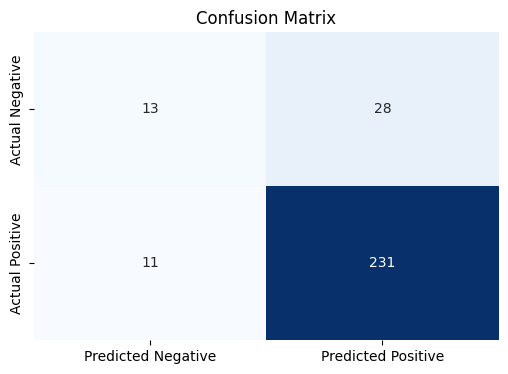

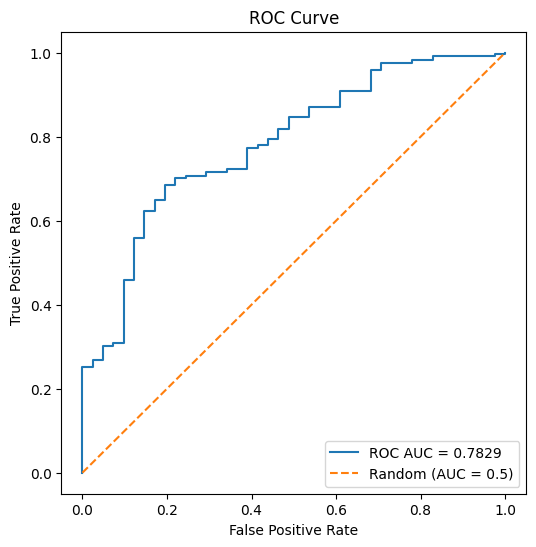

In [21]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

# mb.run_pca(num_components=5)
model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=123,
)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

These results show a fairly low AUC (Area under curve) as well as a relatively low F1 score for the macro avg.


### Test 2

Next try SMOTE - synthetically generate new samples based on minority samples.

Training Balance for weight_transfer_type:
0    965
1    965
Name: weight_transfer_type, dtype: int64
Mean ROC AUC from cross validation: 0.965
Min ROC AUC from cross validation: 0.940
Max ROC AUC from cross validation: 0.988


/Users/nathanielgreen/Dev-Local/pose_parser/pose_parser/pose_parser/learning/model_builder.py:278: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  )


Classification Metrics:
Accuracy: 0.8481
Precision: 0.8902
Recall: 0.9380
F1 Score: 0.9135
ROC AUC: 0.7777

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.32      0.38        41
           1       0.89      0.94      0.91       242

    accuracy                           0.85       283
   macro avg       0.68      0.63      0.65       283
weighted avg       0.83      0.85      0.84       283



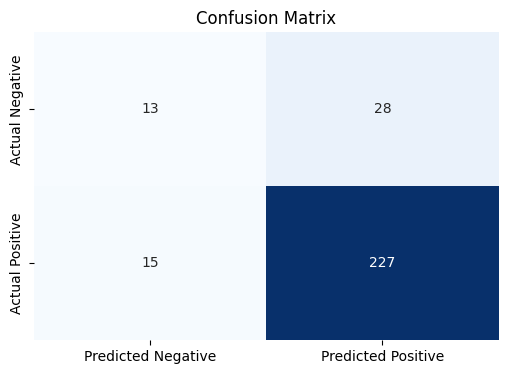

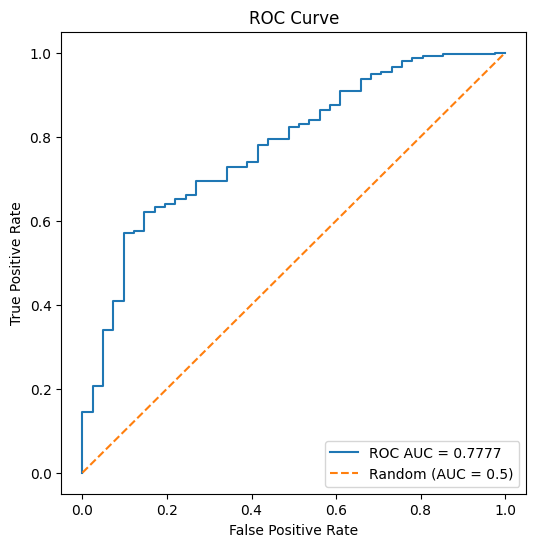

In [16]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

# mb.run_pca(num_components=5)
model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=True,
    random_state=123,
)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

Simlar to results without SMOTE.

### Test 3

Downsample the majority class.

Training Balance for weight_transfer_type:
1    167
0    167
Name: weight_transfer_type, dtype: int64
Top 25 features
[{'angles_max.frame-22-line_5_6__line_6_7_angle_2d_degrees': '0.4271267361998467%'}, {'angles_max.frame-25-line_5_6__line_6_7_angle_2d_degrees': '0.31050105392229144%'}, {'angles_avg.frame-22-line_5_6__line_6_7_angle_2d_degrees': '0.30280101375554325%'}, {'angles_max.frame-23-line_5_6__line_6_7_angle_2d_degrees': '0.29720671987396824%'}, {'angles_max.frame-21-line_5_6__line_6_7_angle_2d_degrees': '0.2966104826515168%'}, {'angles_avg.frame-18-line_5_6__line_6_7_angle_2d_degrees': '0.28995126590930825%'}, {'angles_avg.frame-17-line_5_6__line_6_7_angle_2d_degrees': '0.28840438534334994%'}, {'angles_max.frame-20-line_5_6__line_6_7_angle_2d_degrees': '0.2843418916661714%'}, {'angles_max.frame-12-line_5_6__line_6_7_angle_2d_degrees': '0.2832337909462152%'}, {'angles_avg.frame-24-line_5_6__line_6_7_angle_2d_degrees': '0.26282716394518796%'}, {'angles_avg.frame-23-line_5_6__lin

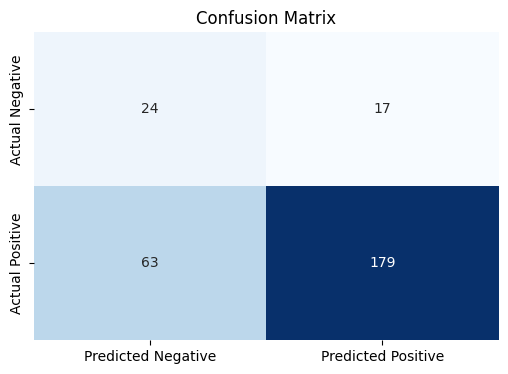

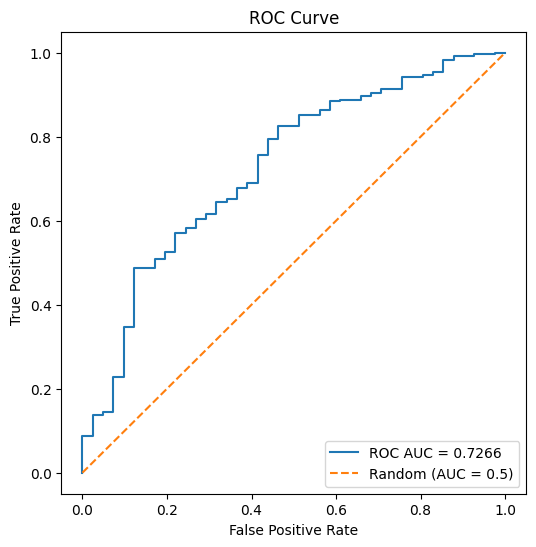

In [20]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

# mb.run_pca(num_components=5)
model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=False,
    downsample_majority=True,
    use_SMOTE=False,
    random_state=123,
)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

Overall the downsampling strategy seems slightly worse. That makes sense as they are not very many examples.

### Test 4 - Leaving the dataset unbalanced

Training Balance for weight_transfer_type:
1    965
0    167
Name: weight_transfer_type, dtype: int64
Top 25 features
{'angles_max.frame-21-line_5_6__line_6_7_angle_2d_degrees': '0.45391350467136127%'}
{'angles_max.frame-22-line_5_6__line_6_7_angle_2d_degrees': '0.39571625771941665%'}
{'angles_avg.frame-20-line_5_6__line_6_7_angle_2d_degrees': '0.38863751504401756%'}
{'angles_avg.frame-19-line_5_6__line_6_7_angle_2d_degrees': '0.3772313687384362%'}
{'angles_avg.frame-21-line_5_6__line_6_7_angle_2d_degrees': '0.3449193633111493%'}
{'angles_avg.frame-22-line_5_6__line_6_7_angle_2d_degrees': '0.34386690912504014%'}
{'angles_avg.frame-18-line_5_6__line_6_7_angle_2d_degrees': '0.3377503495704255%'}
{'angles_max.frame-17-line_5_6__line_6_7_angle_2d_degrees': '0.32456570540776286%'}
{'angles_max.frame-20-line_5_6__line_6_7_angle_2d_degrees': '0.31767825256357474%'}
{'angles_max.frame-15-line_3_4__line_25_26_angle_2d_degrees': '0.3035670400489272%'}
{'angles_avg.frame-17-line_5_6__line_6_7_ang

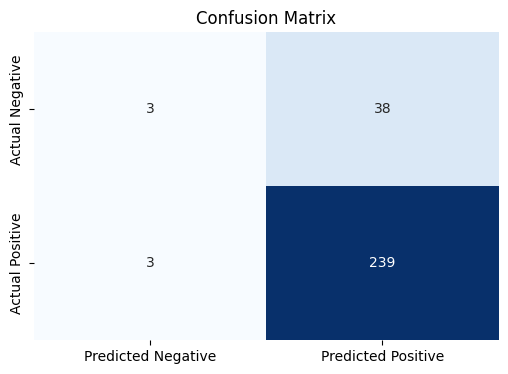

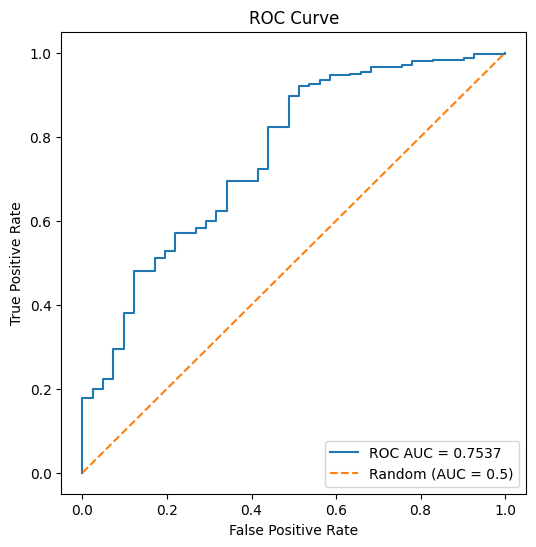

In [22]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

# mb.run_pca(num_components=5)
model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=False,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=123,
)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

These results also look similar.

### Test 5

In general each technique gave similar results. I also fixed the train test split for each case. Let's try a few runs of oversampling the minority class (without SMOTE on some different train test splits). I want to try this because the cross validation scores are tending to have very nice ROC AUC scores (in the 90s) and so just want to rule out that the particular split I'm using for the previous scores isn't particularly bad.

Training Balance for weight_transfer_type:
1    971
0    971
Name: weight_transfer_type, dtype: int64
Top 25 features
{'angles_max.frame-21-line_5_6__line_6_7_angle_2d_degrees': '0.37405887694934264%'}
{'angles_avg.frame-21-line_5_6__line_6_7_angle_2d_degrees': '0.33791450496789166%'}
{'angles_avg.frame-21-line_3_4__line_25_26_angle_2d_degrees': '0.29719235395327476%'}
{'angles_max.frame-12-line_3_4__line_25_26_angle_2d_degrees': '0.2803347654727033%'}
{'angles_avg.frame-18-line_3_4__line_25_26_angle_2d_degrees': '0.2779264903043805%'}
{'angles_avg.frame-14-line_3_4__line_25_26_angle_2d_degrees': '0.26367731702542474%'}
{'angles_avg.frame-19-line_2_3__line_3_4_angle_2d_degrees': '0.24833196951694805%'}
{'angles_max.frame-17-line_3_4__line_25_26_angle_2d_degrees': '0.23617960888591016%'}
{'angles_max.frame-2-line_1_5__line_5_6_angle_2d_degrees': '0.2333834496855864%'}
{'angles_max.frame-11-line_3_4__line_25_26_angle_2d_degrees': '0.23161445330681418%'}
{'angles_avg.frame-15-line_3_4__li

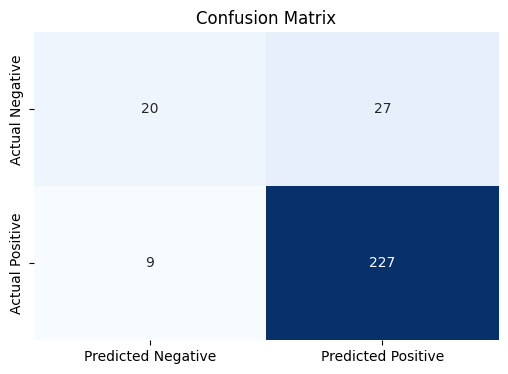

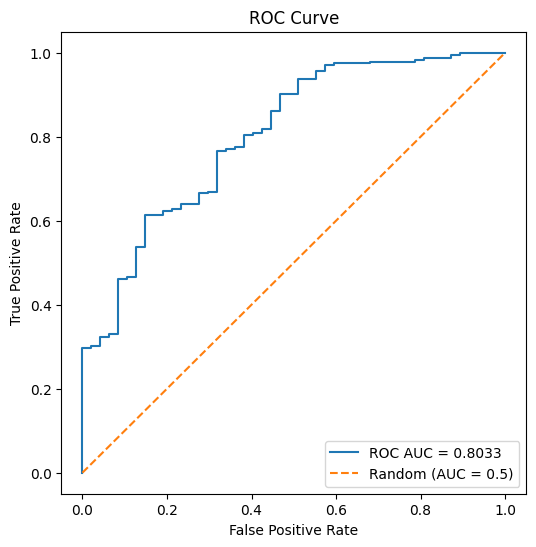

In [25]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

# mb.run_pca(num_components=5)
model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=300,
)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

Training Balance for weight_transfer_type:
1    970
0    970
Name: weight_transfer_type, dtype: int64
Top 25 features
{'angles_avg.frame-21-line_5_6__line_6_7_angle_2d_degrees': '0.30229642149177366%'}
{'angles_max.frame-24-line_1_2__line_2_3_angle_2d_degrees': '0.29364734640716383%'}
{'angles_avg.frame-23-line_1_2__line_2_3_angle_2d_degrees': '0.2731247599537895%'}
{'angles_avg.frame-20-line_3_4__line_25_26_angle_2d_degrees': '0.27247069245099964%'}
{'angles_avg.frame-16-line_3_4__line_25_26_angle_2d_degrees': '0.262800793925136%'}
{'angles_max.frame-25-line_3_4__line_25_26_angle_2d_degrees': '0.2527628086915553%'}
{'angles_avg.frame-20-line_5_6__line_6_7_angle_2d_degrees': '0.25088983611453664%'}
{'angles_max.frame-14-line_1_2__line_2_3_angle_2d_degrees': '0.24783899939829812%'}
{'angles_avg.frame-7-line_0_15__line_25_26_angle_2d_degrees': '0.24039517636116112%'}
{'angles_avg.frame-22-line_5_6__line_6_7_angle_2d_degrees': '0.23937700309123758%'}
{'angles_avg.frame-21-line_3_4__line_2

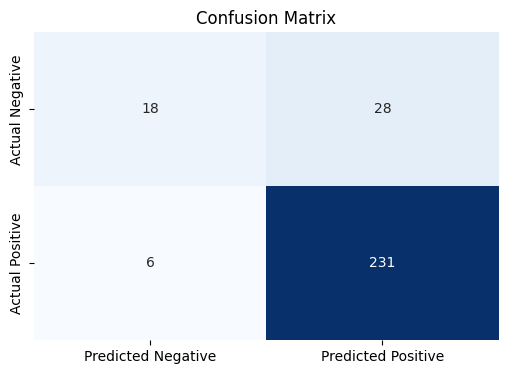

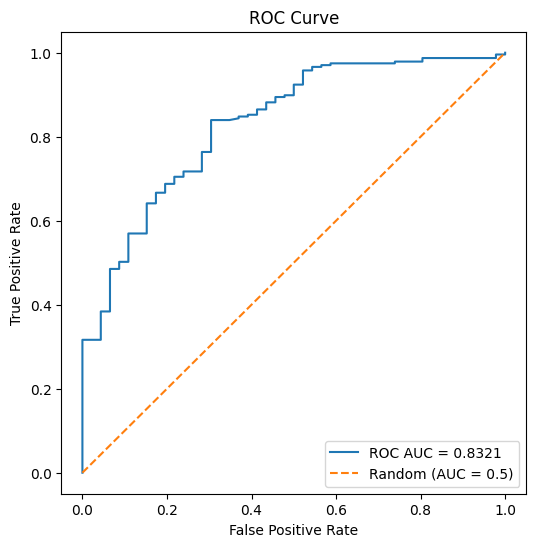

In [26]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

# mb.run_pca(num_components=5)
model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=423,
)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

Training Balance for weight_transfer_type:
1    958
0    958
Name: weight_transfer_type, dtype: int64
Top 25 features
{'angles_avg.frame-24-line_1_2__line_2_3_angle_2d_degrees': '0.30698514888619305%'}
{'angles_avg.frame-23-line_1_2__line_2_3_angle_2d_degrees': '0.289015590415664%'}
{'angles_avg.frame-13-line_3_4__line_25_26_angle_2d_degrees': '0.24286141608627254%'}
{'angles_max.frame-21-line_1_2__line_2_3_angle_2d_degrees': '0.2406457610663646%'}
{'angles_avg.frame-22-line_1_2__line_2_3_angle_2d_degrees': '0.2224398980202238%'}
{'angles_avg.frame-20-line_1_2__line_2_3_angle_2d_degrees': '0.21910171660394195%'}
{'angles_avg.frame-3-line_0_15__line_25_26_angle_2d_degrees': '0.2184851778453167%'}
{'angles_max.frame-25-line_1_2__line_2_3_angle_2d_degrees': '0.21724157141878184%'}
{'angles_max.frame-5-line_0_15__line_25_26_angle_2d_degrees': '0.21146167566475355%'}
{'angles_max.frame-22-line_1_2__line_2_3_angle_2d_degrees': '0.2101410152605515%'}
{'angles_avg.frame-21-line_5_6__line_6_7_a

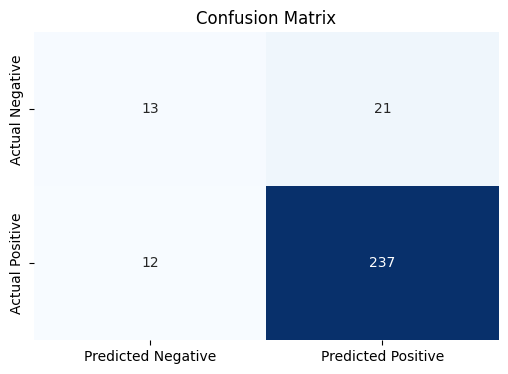

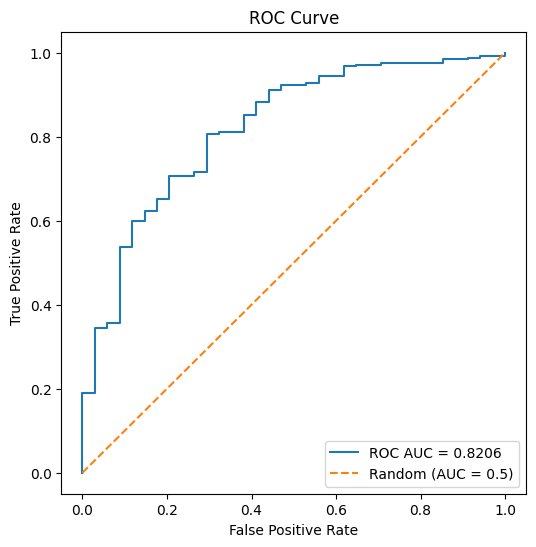

In [31]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

# mb.run_pca(num_components=5)
model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

82% AUC and 89% accuracy is a decent baseline. I have saved this model.

### Test 5 - PCA


Next, going to run PCA on this same train / test split and compare. Trying 5 features...

Training Balance for weight_transfer_type:
1    958
0    958
Name: weight_transfer_type, dtype: int64
PCA Variance Ratio [0.186029   0.13702806 0.08237575 0.06715103 0.05852736]
Mean ROC AUC from cross validation: 0.963
Min ROC AUC from cross validation: 0.932
Max ROC AUC from cross validation: 0.989
Classification Metrics:
Accuracy: 0.8233
Precision: 0.9198
Recall: 0.8755
F1 Score: 0.8971
ROC AUC: 0.6906

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.44      0.38        34
           1       0.92      0.88      0.90       249

    accuracy                           0.82       283
   macro avg       0.62      0.66      0.64       283
weighted avg       0.85      0.82      0.83       283



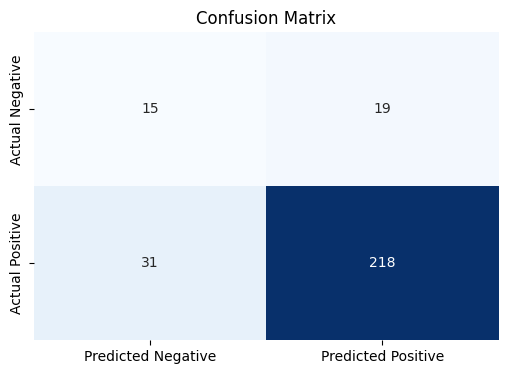

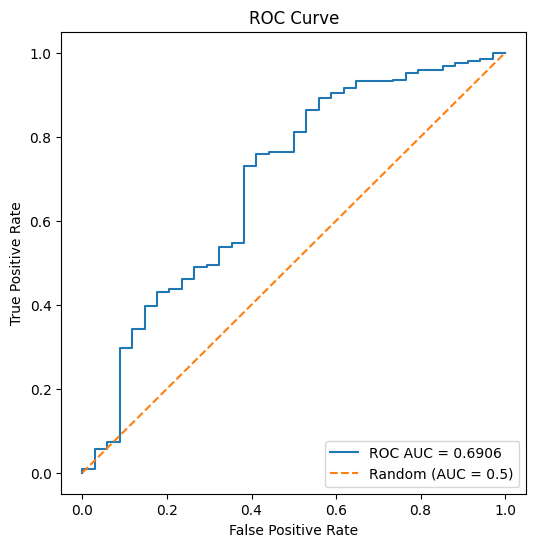

In [34]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
model_builder.run_pca(num_components=5)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

Not quite as good. Will try with a few different component numbers... 2, 11, 25.

Training Balance for weight_transfer_type:
1    958
0    958
Name: weight_transfer_type, dtype: int64
PCA Variance Ratio [0.186029   0.13702806]
Mean ROC AUC from cross validation: 0.966
Min ROC AUC from cross validation: 0.935
Max ROC AUC from cross validation: 0.987
Classification Metrics:
Accuracy: 0.7491
Precision: 0.8973
Recall: 0.8072
F1 Score: 0.8499
ROC AUC: 0.6129

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.32      0.24        34
           1       0.90      0.81      0.85       249

    accuracy                           0.75       283
   macro avg       0.54      0.57      0.54       283
weighted avg       0.81      0.75      0.78       283



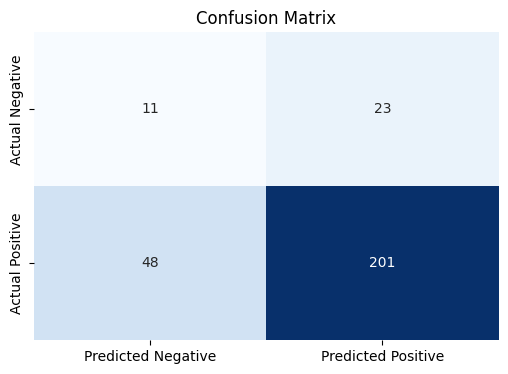

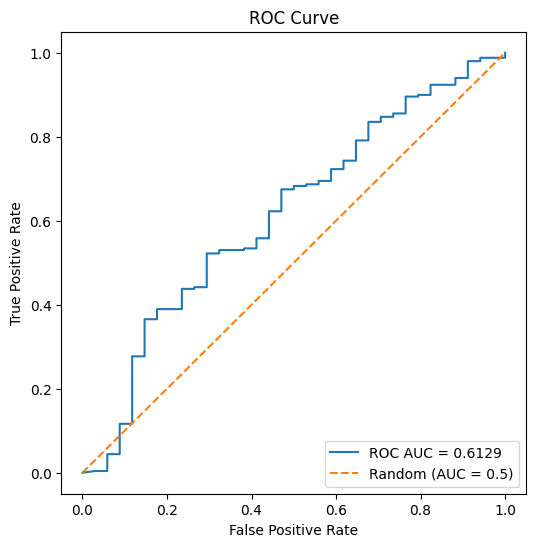

In [35]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
model_builder.run_pca(num_components=2)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

Two components, not so good.

Training Balance for weight_transfer_type:
1    958
0    958
Name: weight_transfer_type, dtype: int64
PCA Variance Ratio [0.186029   0.13702806 0.08237575 0.06715103 0.05852736 0.04541095
 0.03751028 0.03266918 0.02886933 0.02037861 0.01930305]
Mean ROC AUC from cross validation: 0.965
Min ROC AUC from cross validation: 0.927
Max ROC AUC from cross validation: 0.991
Classification Metrics:
Accuracy: 0.8551
Precision: 0.9160
Recall: 0.9197
F1 Score: 0.9178
ROC AUC: 0.7027

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.38      0.39        34
           1       0.92      0.92      0.92       249

    accuracy                           0.86       283
   macro avg       0.65      0.65      0.65       283
weighted avg       0.85      0.86      0.85       283



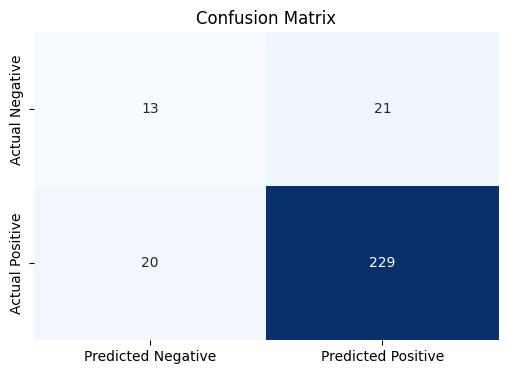

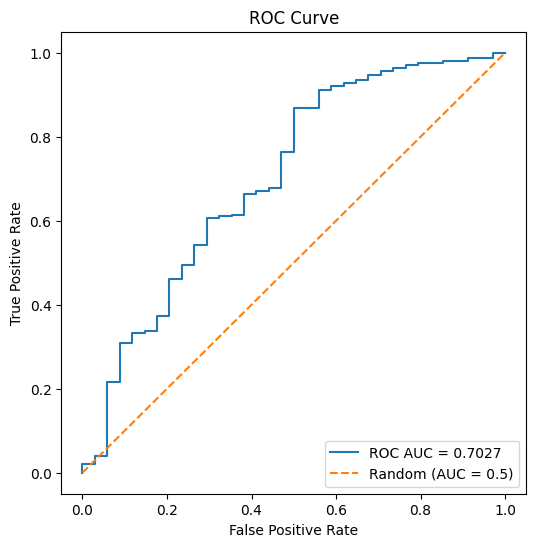

In [36]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
model_builder.run_pca(num_components=11)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

11 slightly better but not as good as using raw features.

Training Balance for weight_transfer_type:
1    958
0    958
Name: weight_transfer_type, dtype: int64
PCA Variance Ratio [0.186029   0.13702806 0.08237575 0.06715103 0.05852736 0.04541095
 0.03751028 0.03266918 0.02886933 0.02037861 0.01930307 0.01872435
 0.01562092 0.01495439 0.01488664 0.01401476 0.01241512 0.01194887
 0.00990014 0.00939903 0.00868459 0.00822363 0.00678515 0.00608804
 0.00571215]
Mean ROC AUC from cross validation: 0.962
Min ROC AUC from cross validation: 0.924
Max ROC AUC from cross validation: 0.983
Classification Metrics:
Accuracy: 0.8763
Precision: 0.9147
Recall: 0.9478
F1 Score: 0.9310
ROC AUC: 0.7172

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.35      0.41        34
           1       0.91      0.95      0.93       249

    accuracy                           0.88       283
   macro avg       0.70      0.65      0.67       283
weighted avg       0.86      0.88      0.87       283



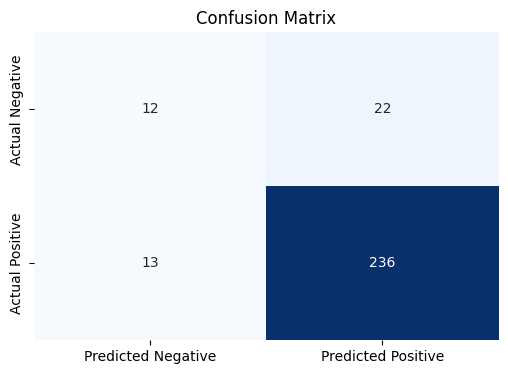

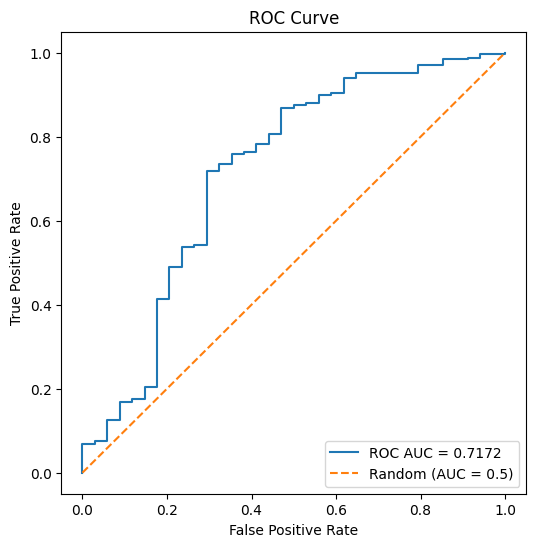

In [37]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
model_builder.run_pca(num_components=25)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

Only small improvement. Let's try one more time with 50 components.

Training Balance for weight_transfer_type:
1    958
0    958
Name: weight_transfer_type, dtype: int64
PCA Variance Ratio [0.186029   0.13702806 0.08237575 0.06715103 0.05852736 0.04541095
 0.03751028 0.03266918 0.02886933 0.02037861 0.01930307 0.01872435
 0.01562092 0.01495439 0.01488664 0.01401476 0.01241512 0.01194887
 0.00990014 0.00939903 0.0086846  0.00822363 0.00678541 0.00608831
 0.00571263 0.00504326 0.00495985 0.00471409 0.00465523 0.00437486
 0.00417368 0.00411399 0.00372651 0.00370592 0.00354478 0.00334679
 0.00310337 0.00303919 0.00295311 0.0027034  0.00246361 0.00233532
 0.00221385 0.00211882 0.00207487 0.00190133 0.0018552  0.00182864
 0.00175467 0.001648  ]
Mean ROC AUC from cross validation: 0.964
Min ROC AUC from cross validation: 0.939
Max ROC AUC from cross validation: 0.987
Classification Metrics:
Accuracy: 0.8587
Precision: 0.8914
Recall: 0.9558
F1 Score: 0.9225
ROC AUC: 0.7297

Classification Report:
              precision    recall  f1-score   support

         

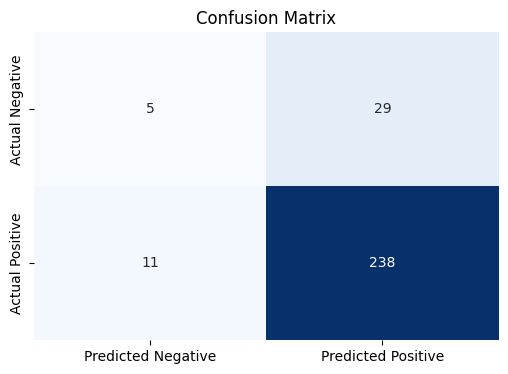

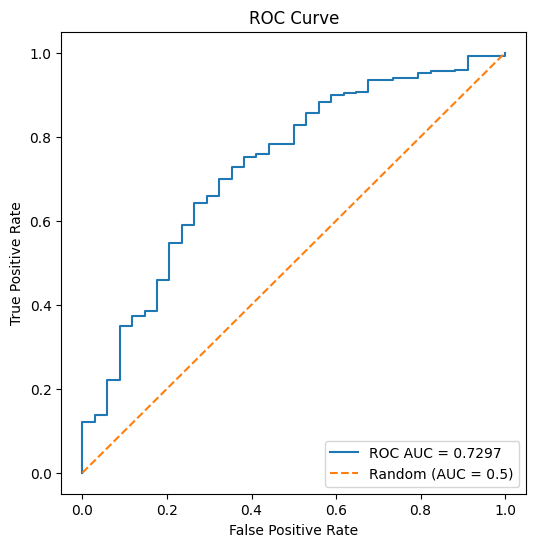

In [38]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
model_builder.run_pca(num_components=50)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

100?

Training Balance for weight_transfer_type:
1    958
0    958
Name: weight_transfer_type, dtype: int64
PCA Variance Ratio [0.186029   0.13702806 0.08237575 0.06715103 0.05852736 0.04541095
 0.03751028 0.03266918 0.02886933 0.02037861 0.01930307 0.01872435
 0.01562092 0.01495439 0.01488664 0.01401476 0.01241512 0.01194887
 0.00990014 0.00939903 0.0086846  0.00822363 0.00678541 0.00608831
 0.00571263 0.00504326 0.00495985 0.00471409 0.00465523 0.00437486
 0.00417368 0.00411399 0.00372651 0.00370592 0.00354478 0.00334679
 0.00310337 0.00303919 0.00295311 0.0027034  0.00246361 0.00233532
 0.00221386 0.00211884 0.00207488 0.00190133 0.00185522 0.00182873
 0.00175471 0.00164842 0.001645   0.00158274 0.0014718  0.00136878
 0.00131232 0.00127095 0.00122706 0.00119341 0.00116799 0.00112369
 0.00106216 0.00099709 0.00093266 0.00090938 0.00086052 0.00085286
 0.00082326 0.00077393 0.00074101 0.00073206 0.00072068 0.0006714
 0.00065457 0.00064458 0.0006239  0.00058742 0.00056876 0.00055973
 0.000554

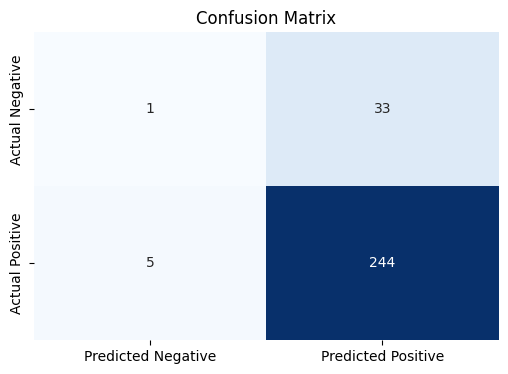

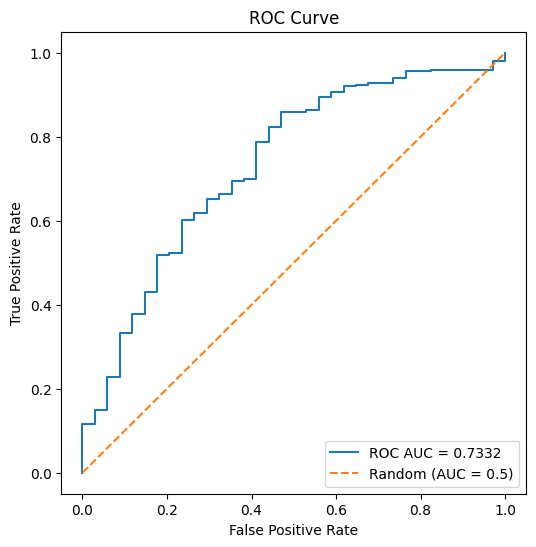

In [39]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
model_builder.run_pca(num_components=100)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

200?

Training Balance for weight_transfer_type:
1    958
0    958
Name: weight_transfer_type, dtype: int64
PCA Variance Ratio [1.86028996e-01 1.37028055e-01 8.23757481e-02 6.71510264e-02
 5.85273628e-02 4.54109470e-02 3.75102804e-02 3.26691848e-02
 2.88693301e-02 2.03786122e-02 1.93030723e-02 1.87243465e-02
 1.56209153e-02 1.49543886e-02 1.48866378e-02 1.40147587e-02
 1.24151234e-02 1.19488711e-02 9.90013571e-03 9.39902696e-03
 8.68460002e-03 8.22363308e-03 6.78540967e-03 6.08830679e-03
 5.71263197e-03 5.04326257e-03 4.95985231e-03 4.71408562e-03
 4.65522957e-03 4.37485831e-03 4.17367517e-03 4.11399055e-03
 3.72650708e-03 3.70591680e-03 3.54477920e-03 3.34679207e-03
 3.10337479e-03 3.03918899e-03 2.95310989e-03 2.70339916e-03
 2.46361475e-03 2.33532497e-03 2.21385758e-03 2.11884465e-03
 2.07487576e-03 1.90133303e-03 1.85521937e-03 1.82873062e-03
 1.75471059e-03 1.64841522e-03 1.64500111e-03 1.58274028e-03
 1.47180469e-03 1.36878042e-03 1.31231911e-03 1.27094915e-03
 1.22705932e-03 1.1934056

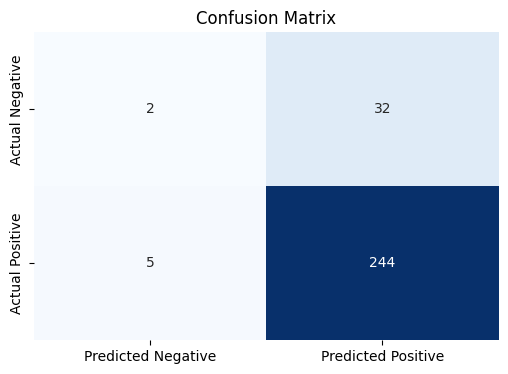

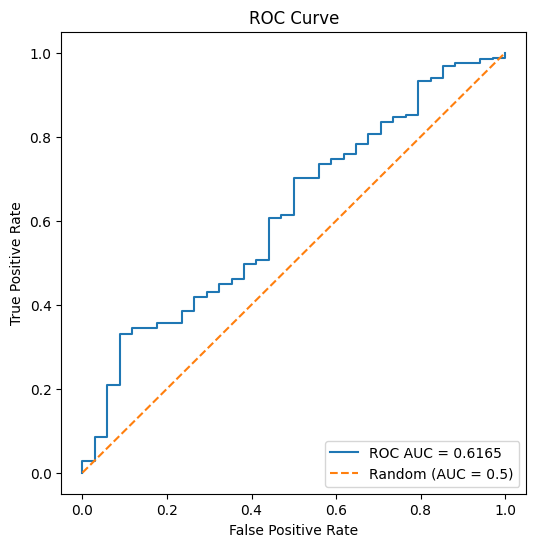

In [40]:
data_file = "./data/annotated_videos/dataset_1679103956737220000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
model_builder.run_pca(num_components=200)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

So peak seems to be in the 100-200 range, but never higher than without PCA for this train / test split.

## Dataset 2
### 45 frame Window, pooled averages, standard dev, max over angle measurements

### Test 1 - baseline test on Random Forest

Training Balance for weight_transfer_type:
1    530
0    530
Name: weight_transfer_type, dtype: int64
Mean ROC AUC from cross validation: 1.000
Min ROC AUC from cross validation: 1.000
Max ROC AUC from cross validation: 1.000
Top 5 features
{'angles_std.line_1_2__line_2_3_angle_2d_degrees': '2.1474039607626194%'}
{'angles_avg.line_2_3__line_3_4_angle_2d_degrees': '2.121533941019437%'}
{'angles_std.line_1_5__line_5_6_angle_2d_degrees': '2.1076607534815124%'}
{'angles_std.line_3_4__line_25_26_angle_2d_degrees': '1.9640955471931818%'}
{'angles_avg.line_1_5__line_5_6_angle_2d_degrees': '1.8427347175298499%'}
Classification Metrics:
Accuracy: 0.8839
Precision: 0.8859
Recall: 0.9925
F1 Score: 0.9362
ROC AUC: 0.8455

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.23      0.36        22
           1       0.89      0.99      0.94       133

    accuracy                           0.88       155
   macro avg       0.86      0.61      

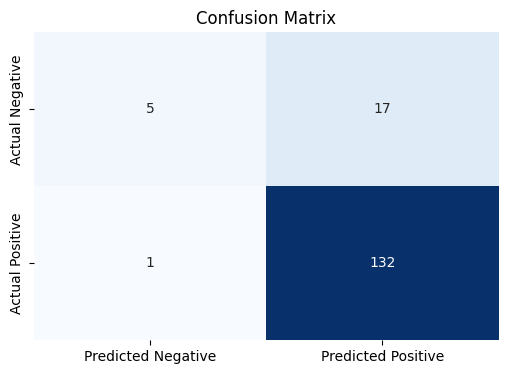

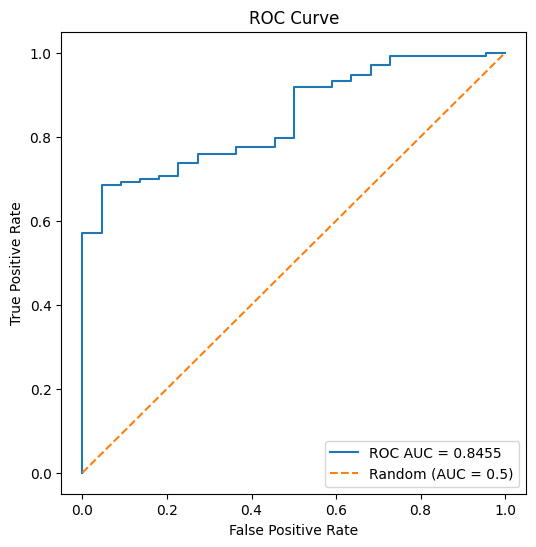

In [43]:
data_file = "./data/annotated_videos/dataset_1679015606654767000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
# model_builder.run_pca(num_components=200)

param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "max_features": randint(3, 20),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params, param_dist=param_dist
)
model_builder.evaluate_model()

This is pretty decent - 88% accuracy with 85% ROC AUC - SAVED THIS MODEL

### Test 2 - random search over hyperparameters for Random Forest

Here, will randomly choose between these params for a Random Forest 20 times and choose the best one...

```
param_dist = {
    "n_estimators": randint(400, 600),
    "max_depth": randint(9, 15),
    "max_features": randint(4, 12),
}
```

Training Balance for weight_transfer_type:
1    530
0    530
Name: weight_transfer_type, dtype: int64
Best random search hyperparameters: {'max_depth': 14, 'max_features': 6, 'n_estimators': 415}
Mean ROC AUC from cross validation: 0.997
Min ROC AUC from cross validation: 0.978
Max ROC AUC from cross validation: 1.000
Top 5 features
{'angles_std.line_1_5__line_25_26_angle_2d_degrees': '1.9202530973822831%'}
{'angles_std.line_1_5__line_5_6_angle_2d_degrees': '1.7821597390531334%'}
{'angles_avg.line_5_6__line_6_7_angle_2d_degrees': '1.6712994695613166%'}
{'angles_avg.line_2_3__line_3_4_angle_2d_degrees': '1.656103647175226%'}
{'angles_std.line_1_2__line_25_26_angle_2d_degrees': '1.6442517196583666%'}
Classification Metrics:
Accuracy: 0.8710
Precision: 0.8693
Recall: 1.0000
F1 Score: 0.9301
ROC AUC: 0.8397

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        22
           1       0.87      1.00      0.93       13

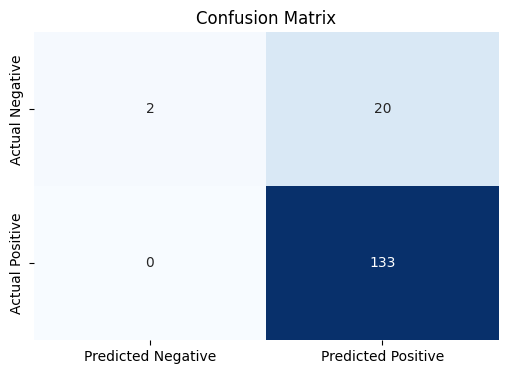

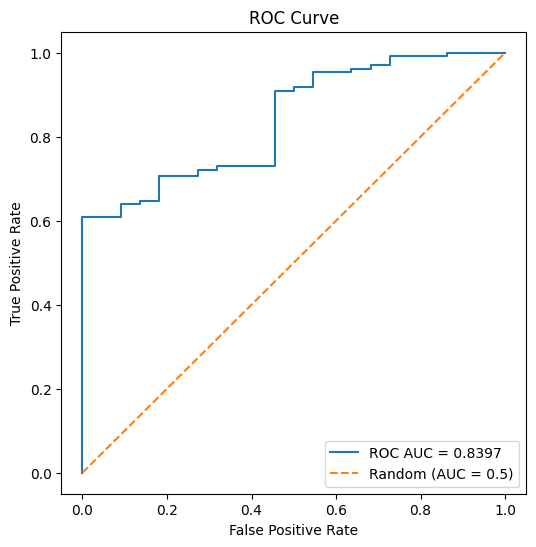

In [47]:
data_file = "./data/annotated_videos/dataset_1679015606654767000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
# model_builder.run_pca(num_components=200)

param_dist = {
    "n_estimators": randint(400, 600),
    "max_depth": randint(9, 15),
    "max_features": randint(4, 12),
}
rf_params = {
    # "class_weight": "balanced_subsample",
    # "class_weight": "balanced",
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=True, params=rf_params, param_dist=param_dist, iterations=25, random_state = 123
)
model_builder.evaluate_model()

Generally, the results are fairly consistent search to search...

### Test 3 - Recursive Feature Elimination on upsampled data

Here, the idea will be to find the best features from the RF classifier and recursively retrain on the best ones. This test will retrain on the top 7 features and then evaluate.

```
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
```

Training Balance for weight_transfer_type:
1    530
0    530
Name: weight_transfer_type, dtype: int64
Feature Ranks
angles_avg.line_1_5__line_5_6_angle_2d_degrees: 1
angles_avg.line_2_3__line_3_4_angle_2d_degrees: 1
angles_avg.line_5_6__line_6_7_angle_2d_degrees: 1
angles_avg.line_12_13__line_13_14_angle_2d_degrees: 1
angles_max.line_3_4__line_25_26_angle_2d_degrees: 1
angles_std.line_3_4__line_25_26_angle_2d_degrees: 1
angles_std.line_1_5__line_5_6_angle_2d_degrees: 1
angles_avg.line_1_5__line_25_26_angle_2d_degrees: 2
angles_std.line_1_2__line_2_3_angle_2d_degrees: 3
angles_avg.line_16_18__line_25_26_angle_2d_degrees: 4
angles_avg.line_1_2__line_2_3_angle_2d_degrees: 5
angles_std.line_1_5__line_25_26_angle_2d_degrees: 6
angles_std.line_10_11__line_11_24_angle_2d_degrees: 7
angles_max.line_5_6__line_6_7_angle_2d_degrees: 8
angles_avg.line_15_17__line_25_26_angle_2d_degrees: 9
angles_std.line_13_14__line_25_26_angle_2d_degrees: 10
angles_avg.line_13_14__line_25_26_angle_2d_degrees: 11


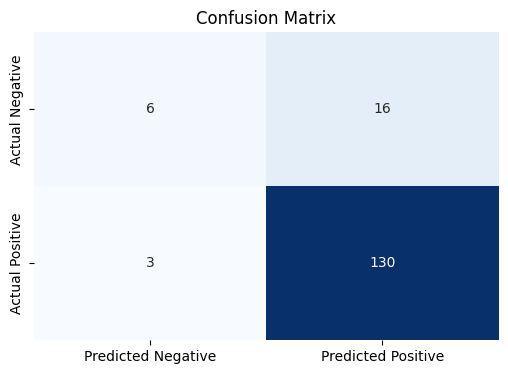

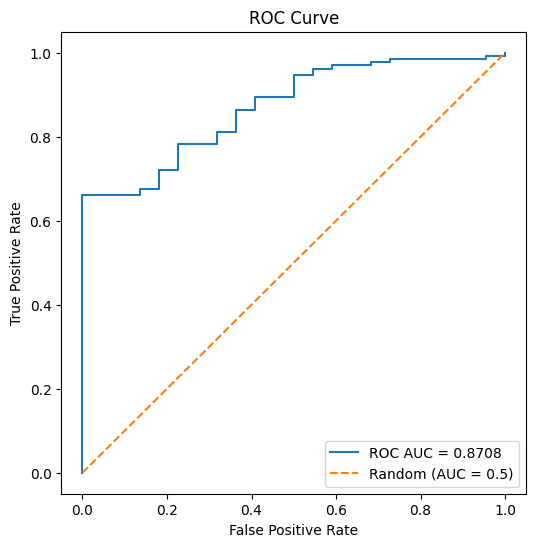

In [51]:
data_file = "./data/annotated_videos/dataset_1679015606654767000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)

rf_params = {
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params
)
model_builder.run_recursive_feature_estimation(num_features=7)
model_builder.evaluate_model()

This is pretty good! Will save this model.

Top features:

```
angles_avg.line_1_5__line_5_6_angle_2d_degrees: 1
angles_avg.line_2_3__line_3_4_angle_2d_degrees: 1
angles_avg.line_5_6__line_6_7_angle_2d_degrees: 1
angles_avg.line_12_13__line_13_14_angle_2d_degrees: 1
angles_max.line_3_4__line_25_26_angle_2d_degrees: 1
angles_std.line_3_4__line_25_26_angle_2d_degrees: 1
angles_std.line_1_5__line_5_6_angle_2d_degrees: 1
```

### Test 4 - RFE on the original imbalanced dataset

Training Balance for weight_transfer_type:
1    530
0     87
Name: weight_transfer_type, dtype: int64
Feature Ranks
angles_avg.line_9_10__line_25_26_angle_2d_degrees: 1
angles_avg.line_0_15__line_25_26_angle_2d_degrees: 1
angles_avg.line_16_18__line_25_26_angle_2d_degrees: 1
angles_avg.line_5_6__line_6_7_angle_2d_degrees: 1
angles_max.line_3_4__line_25_26_angle_2d_degrees: 1
angles_std.line_1_8__line_25_26_angle_2d_degrees: 1
angles_std.line_3_4__line_25_26_angle_2d_degrees: 1
angles_avg.line_8_12__line_25_26_angle_2d_degrees: 2
angles_std.line_1_5__line_5_6_angle_2d_degrees: 3
angles_max.line_0_15__line_25_26_angle_2d_degrees: 4
angles_max.line_5_6__line_6_7_angle_2d_degrees: 5
angles_avg.line_1_5__line_5_6_angle_2d_degrees: 6
angles_std.line_1_2__line_25_26_angle_2d_degrees: 7
angles_avg.line_15_17__line_25_26_angle_2d_degrees: 8
angles_std.line_13_14__line_25_26_angle_2d_degrees: 9
angles_std.line_1_5__line_25_26_angle_2d_degrees: 10
angles_avg.line_3_4__line_25_26_angle_2d_degrees:

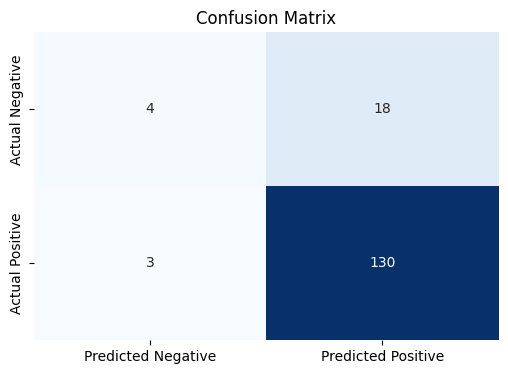

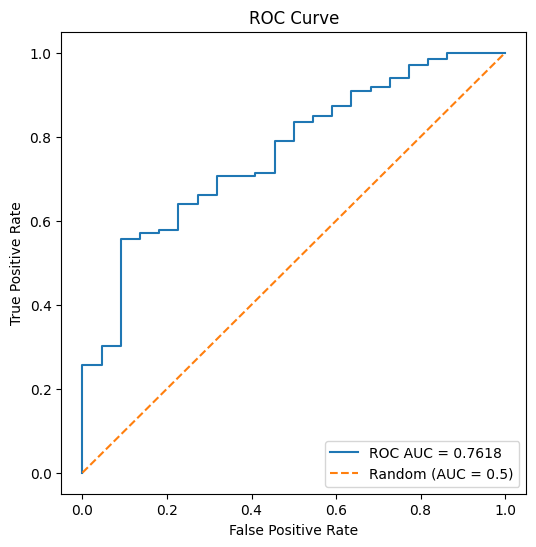

In [53]:
data_file = "./data/annotated_videos/dataset_1679015606654767000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=False,
    upsample_minority=False,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)

rf_params = {
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params
)
model_builder.run_recursive_feature_estimation(num_features=7)
model_builder.evaluate_model()

This is not as good an AUC but overall a decent result given the imbalance. It seems the upsampling is a good idea. I'll constrast this with downsampling.

Top features:

```
angles_avg.line_9_10__line_25_26_angle_2d_degrees: 1
angles_avg.line_0_15__line_25_26_angle_2d_degrees: 1
angles_avg.line_16_18__line_25_26_angle_2d_degrees: 1
angles_avg.line_5_6__line_6_7_angle_2d_degrees: 1
angles_max.line_3_4__line_25_26_angle_2d_degrees: 1
angles_std.line_1_8__line_25_26_angle_2d_degrees: 1
angles_std.line_3_4__line_25_26_angle_2d_degrees: 1
```

Compare to previous (upsampled) - mostly different. Hmm:

```
angles_avg.line_1_5__line_5_6_angle_2d_degrees: 1
angles_avg.line_2_3__line_3_4_angle_2d_degrees: 1
angles_avg.line_5_6__line_6_7_angle_2d_degrees: 1
angles_avg.line_12_13__line_13_14_angle_2d_degrees: 1
angles_max.line_3_4__line_25_26_angle_2d_degrees: 1
angles_std.line_3_4__line_25_26_angle_2d_degrees: 1
angles_std.line_1_5__line_5_6_angle_2d_degrees: 1
```

### Test 5 - RFE with downsampled majority class

Training Balance for weight_transfer_type:
1    87
0    87
Name: weight_transfer_type, dtype: int64
Feature Ranks
angles_avg.line_1_5__line_25_26_angle_2d_degrees: 1
angles_avg.line_1_2__line_2_3_angle_2d_degrees: 1
angles_avg.line_12_13__line_13_14_angle_2d_degrees: 1
angles_max.line_3_4__line_25_26_angle_2d_degrees: 1
angles_std.line_1_2__line_25_26_angle_2d_degrees: 1
angles_std.line_1_5__line_25_26_angle_2d_degrees: 1
angles_std.line_3_4__line_25_26_angle_2d_degrees: 1
angles_avg.line_5_6__line_6_7_angle_2d_degrees: 2
angles_max.line_1_5__line_25_26_angle_2d_degrees: 3
angles_std.line_1_8__line_25_26_angle_2d_degrees: 4
angles_std.line_1_5__line_5_6_angle_2d_degrees: 5
angles_std.line_0_1__line_1_2_angle_2d_degrees: 6
angles_avg.line_1_5__line_5_6_angle_2d_degrees: 7
angles_std.line_1_2__line_2_3_angle_2d_degrees: 8
angles_max.line_0_15__line_15_17_angle_2d_degrees: 9
angles_max.line_0_15__line_25_26_angle_2d_degrees: 10
angles_max.line_1_5__line_5_6_angle_2d_degrees: 11
angles_max

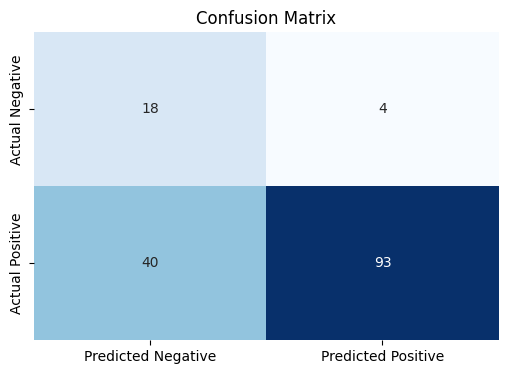

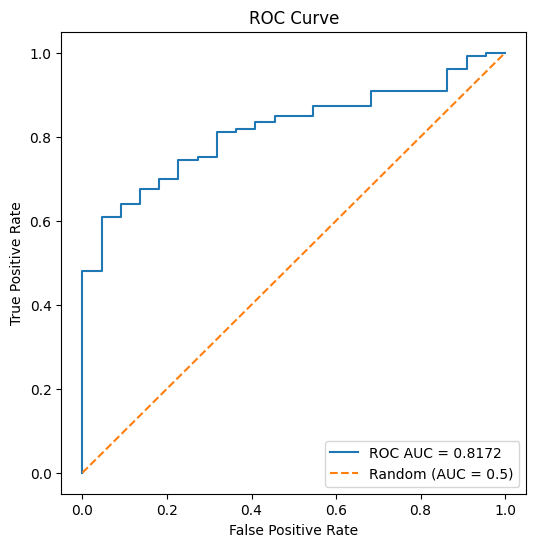

In [54]:
data_file = "./data/annotated_videos/dataset_1679015606654767000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=False,
    downsample_majority=True,
    use_SMOTE=False,
    random_state=40002,
)

rf_params = {
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params
)
model_builder.run_recursive_feature_estimation(num_features=7)
model_builder.evaluate_model()

Much lower accuracy - AUC fairly consistent. I think it's tough with this few samples.

### Test 6 - Random Forest with only the top 7 features from RFE, upsampling minority

Training Balance for weight_transfer_type:
1    530
0    530
Name: weight_transfer_type, dtype: int64
Mean ROC AUC from cross validation: 1.000
Min ROC AUC from cross validation: 1.000
Max ROC AUC from cross validation: 1.000
Top 5 features
{'angles_avg.line_16_18__line_25_26_angle_2d_degrees': '23.208074075709924%'}
{'angles_avg.line_9_10__line_25_26_angle_2d_degrees': '17.58613049327652%'}
{'weight_transfer_type': '15.525633697335635%'}
{'angles_avg.line_5_6__line_6_7_angle_2d_degrees': '15.186355437504762%'}
{'angles_avg.line_0_15__line_25_26_angle_2d_degrees': '14.70751334654806%'}
Classification Metrics:
Accuracy: 0.8452
Precision: 0.8978
Recall: 0.9248
F1 Score: 0.9111
ROC AUC: 0.6945

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.36      0.40        22
           1       0.90      0.92      0.91       133

    accuracy                           0.85       155
   macro avg       0.67      0.64      0.66       155
weig

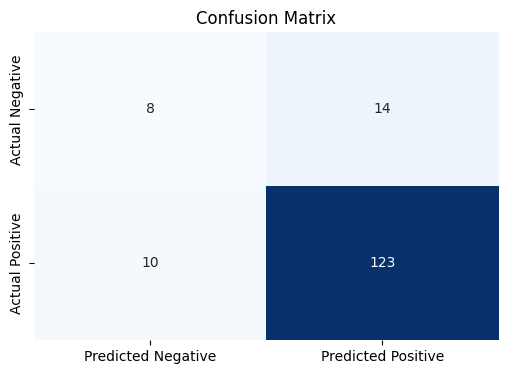

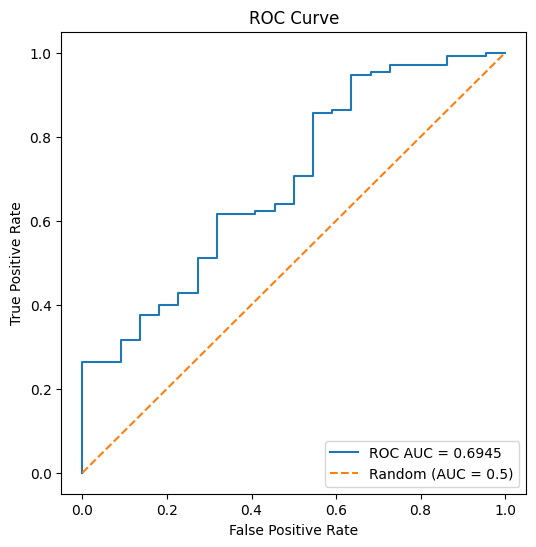

In [57]:
data_file = "./data/annotated_videos/dataset_1679015606654767000.csv"

# reload model builder class (iterating on it a lot)
importlib.reload(mb)
model_builder = mb.ModelBuilder()

column_whitelist = [
   "weight_transfer_type",
   "angles_avg.line_9_10__line_25_26_angle_2d_degrees",
   "angles_avg.line_0_15__line_25_26_angle_2d_degrees",
   "angles_avg.line_16_18__line_25_26_angle_2d_degrees",
   "angles_avg.line_5_6__line_6_7_angle_2d_degrees",
   "angles_max.line_3_4__line_25_26_angle_2d_degrees",
   "angles_std.line_1_8__line_25_26_angle_2d_degrees",
   "angles_std.line_3_4__line_25_26_angle_2d_degrees",
]

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)

rf_params = {
    "n_estimators": 600,
    "max_depth": 9,
    "max_leaf_nodes": 63,
}

model_builder.train_random_forest(
    use_random_search=False, params=rf_params
)
model_builder.evaluate_model()

Not as good. Hmm...

# Save current model and related data to files

In [52]:
""" WRITE NOTES ON THIS RUN HERE """
notes = """
    Dataset notes:
    45 frame window with pooled angle features (avg / std / max)
    This training data upsamples the minority class by random sample.

    Model notes:
    Random Forest classifier trained with
        "n_estimators": 600,
        "max_depth": 9,
        "max_leaf_nodes": 63,
    """

model_builder.save_model_and_datasets(notes=notes)

Saved model to pickle!
